In [1]:
import os.path as op

from wordcloud import WordCloud
import plotly.express as px
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from utils import _cogat_vocabulary, _generate_counts

In [2]:
sns.set_theme(style="white")
FONTSIZE = 12
NEUROSCOUT_OWNER_ID = 5761
DPI = 300

CMAP = mpl.colormaps.get_cmap("tab20")

In [3]:
data_dir = "../data"
pubget_dir = op.join(data_dir, "pubget_data")
query_extensive = "query_875641cf4cbc22f32027447cd62fca27"
query_neurovault = "query_a444c1d1cc79f746a519d97ce9672089"
fig_dir = "./neurovault_data"
neurovault_dir = op.join(data_dir, "nv-data", "february_2024")

In [4]:
def _n_colls(df):
    return df.collection_id.unique().size


def _n_cogats(df):
    return df.cognitive_paradigm_cogatlas_id.unique().size


def _n_images(df):
    return df.image_id.unique().size


def _check_string(s):
    return all(c.isdigit() for c in s)


def _convert_collection_id(collection_id, collections_df):
    if str(collection_id).isalpha():
        matches = collections_df[collections_df.private_token == collection_id]
        return matches.id.values[0] if matches.size > 0 else None
    else:
        return int(collection_id) if _check_string(str(collection_id)) else None


def _plot_hist(series, x_label):
    df = pd.DataFrame(series)
    df.index = df.index.astype(str)
    df = df.rename(columns={df.columns[0]: x_label})

    fig = px.bar(
        df,
        x=x_label,
        orientation="h",
    )

    return fig


def _plot_pie(
        data, 
        values, 
        names,
        width=1.5,
        height=1.5,
        textinfo="value+percent", 
        text_inside=False, 
        reversed=False,
    ):
    n_colors = len(data[names].unique())
    cmap = (
        px.colors.qualitative.G10[:n_colors][::-1]
        if reversed
        else px.colors.qualitative.G10[:n_colors]
    )
    fig = px.pie(
        data,
        values=values,
        names=names,
        color_discrete_sequence=cmap,
    )
    fig.update_layout(
        height=height * DPI,
        width=width * DPI,
    )
    fig.update_traces(textinfo=textinfo)
    if text_inside:
        fig.update_traces(textposition="inside", textinfo="value+percent+label")
    return fig


def _join_pubget_queries(pubget_dir, queries):
    assert len(queries) > 0

    coordinates = pd.DataFrame(columns=["pmcid", "table_id", "table_label", "x", "y", "z"])
    metadata = pd.DataFrame(
        columns=["pmcid", "pmid", "doi", "title", "publication_year", "license"]
    )
    neurovault = pd.DataFrame(columns=["pmcid", "collection_id"])
    for query in queries:
        coordinates = pd.merge(
            coordinates,
            pd.read_csv(
                op.join(pubget_dir, query, "subset_allArticles_extractedData", "coordinates.csv")
            ),
            how="outer",
        )
        metadata = pd.merge(
            metadata,
            pd.read_csv(
                op.join(pubget_dir, query, "subset_allArticles_extractedData", "metadata.csv")
            ),
            how="outer",
        )
        neurovault = pd.merge(
            neurovault,
            pd.read_csv(
                op.join(
                    pubget_dir,
                    query,
                    "subset_allArticles_extractedData",
                    "neurovault_collections.csv",
                )
            ),
            how="outer",
        )

    return coordinates, metadata, neurovault


In [5]:
collections = pd.read_csv(op.join(neurovault_dir, "statmaps_collection.csv"))
basecollectionitem = pd.read_csv(op.join(neurovault_dir, "statmaps_basecollectionitem.csv"))
statisticmap = pd.read_csv(op.join(neurovault_dir, "statmaps_statisticmap.csv"))
cogat_task = pd.read_csv(op.join(neurovault_dir, "statmaps_cognitiveatlastask.csv"))
image = pd.read_csv(op.join(neurovault_dir, "statmaps_image.csv"))
image_merged = pd.merge(
    image, basecollectionitem, left_on="basecollectionitem_ptr_id", right_on="id"
)
statisticmap_merged = pd.merge(
    statisticmap, image_merged, left_on="image_ptr_id", right_on="basecollectionitem_ptr_id"
)
collections = pd.merge(
    collections,
    basecollectionitem.groupby("collection_id")
    .size()
    .reset_index()
    .rename(columns={0: "n_images"}),
    left_on="id",
    right_on="collection_id",
)
collections = collections[collections.n_images > 0]
collections = collections[collections.owner_id != NEUROSCOUT_OWNER_ID]

collections_pmid_df = pd.read_csv(op.join(data_dir, "nv_collections.csv"))
collections_pmid_df["collection_id"] = collections_pmid_df["collection_id"].astype("int64")
statisticmap_colelctions = pd.read_csv(op.join(data_dir, "nv_collections_images.csv"))
pmid_text = pd.read_csv(op.join(data_dir, "pmid_text.csv"))

/var/folders/m9/_ygtgkg17990695673wz4l78j5bsz9/T/ipykernel_35559/3484940282.py:1: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  collections = pd.read_csv(op.join(neurovault_dir, "statmaps_collection.csv"))


/var/folders/m9/_ygtgkg17990695673wz4l78j5bsz9/T/ipykernel_35559/3484940282.py:3: DtypeWarning: Columns (4,5,7,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  statisticmap = pd.read_csv(op.join(neurovault_dir, "statmaps_statisticmap.csv"))
/var/folders/m9/_ygtgkg17990695673wz4l78j5bsz9/T/ipykernel_35559/3484940282.py:5: DtypeWarning: Columns (2,3,6,7,16,18,19,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  image = pd.read_csv(op.join(neurovault_dir, "statmaps_image.csv"))


In [6]:
neurosynth_nv_fn = op.join(data_dir, "neurosynth", "neurovault_collections.csv")
neurosynth_metadata_fn = op.join(data_dir, "neurosynth", "metadata.csv")
neurosynth_nv_df = pd.read_csv(neurosynth_nv_fn)
neurosynth_metadata_df = pd.read_csv(neurosynth_metadata_fn)

# Convert private_token to collection_id
collection_ids = neurosynth_nv_df["collection_id"].to_list()
neurosynth_nv_df["collection_id"] = [
    _convert_collection_id(id_, collections) for id_ in collection_ids
]

# Get PMIDs and PMCIDs from metadata
neurosynth_nv_df = pd.merge(neurosynth_nv_df, neurosynth_metadata_df[["pmid", "doi"]], on="pmid")
neurosynth_nv_df = neurosynth_nv_df.reindex(columns=["pmid", "doi", "collection_id"])
neurosynth_nv_df = neurosynth_nv_df.rename(columns={"doi": "secondary_doi"})
neurosynth_nv_df["pmid"] = neurosynth_nv_df["pmid"].astype("Int64")
neurosynth_nv_df = neurosynth_nv_df.dropna(
    subset=["collection_id"]
)  # Some private collections couldnt be mapped to public ones

# Get collections found by pubget
nv_coll = collections_pmid_df["collection_id"].to_list()
pubget_nv_coll = neurosynth_nv_df["collection_id"].to_list()
matching_ids = np.intersect1d(nv_coll, pubget_nv_coll)

pubget_mask = ~neurosynth_nv_df["collection_id"].isin(matching_ids)
neurosynth_nv_df = neurosynth_nv_df[pubget_mask]

# Select unique collections
neurosynth_nv_df = neurosynth_nv_df.sort_values("pmid")
neurosynth_nv_df = neurosynth_nv_df.drop_duplicates("collection_id", keep="first")

# Get collection names
neurosynth_nv_df = pd.merge(
    neurosynth_nv_df, collections[["id", "name"]], left_on="collection_id", right_on="id"
)
neurosynth_nv_df = neurosynth_nv_df.rename(columns={"name": "collection_name"})
neurosynth_nv_df = neurosynth_nv_df.drop(columns="id")
neurosynth_nv_df["source"] = "neurosynth"

print(f"Found {neurosynth_nv_df.shape[0]} new collections with using the pubget search")

# Concatenate the collections
collections_pmid_df = pd.concat(
    [collections_pmid_df, neurosynth_nv_df], ignore_index=True, sort=False
)

Found 26 new collections with using the pubget search


In [99]:
neurosynth_nv_df

,pmid,secondary_doi,collection_id,collection_name,source
0,29964190,10.1016/j.neuroimage.2018.06.076,3329,Movie clips,neurosynth
1,29964190,10.1016/j.neuroimage.2018.06.076,3330,Visual object recognition,neurosynth
2,30999087,10.1016/j.bandc.2019.04.002,4214,Statistical maps (unthresholded),neurosynth
3,31472251,10.1016/j.neuroimage.2019.116133,5550,Frontal cortex differentiates betweenfree and ...,neurosynth
4,31487547,10.1016/j.neuroimage.2019.116150,5654,"Effects of heart rate, respiratory flow, cardi...",neurosynth
5,31525499,10.1016/j.neuroimage.2019.116193,4430,False Belief Processing,neurosynth
6,32800754,10.1016/j.bpsc.2020.05.013,6628,Psychosis_ML_maps_fMRI,neurosynth
7,33508499,10.1016/j.bpsc.2021.01.003,8519,SUDMEX_TMS: The Mexican dataset of an rTMS cli...,neurosynth
8,33511981,10.1093/cercor/bhaa404,8941,Neural correlates of interpersonal space perme...,neurosynth
9,33524573,10.1016/j.neuroimage.2021.117820,9086,FADE_BMS/cvLME_maps,neurosynth


In [ ]:
# collections.groupby("owner_id").size().sort_values(ascending=False).to_csv("collections_owner.csv")
# collections.groupby("owner_id").size()
# data_dict = [eval(image) for image in image["data"].dropna().to_list()]
# not_empty_dict = [d for d in data_dict if len(d) > 0]
# len(data_dict)
# len(not_empty_dict)

# NeuroVault data


### Collections with coordinates


In [7]:
coordinates, metadata, neurovault = _join_pubget_queries(
    pubget_dir, [query_neurovault, query_extensive]
)

In [8]:
coordinate_counts = (
    coordinates.groupby("pmcid")
    .count()
    .reset_index()[["pmcid", "table_id"]]
    .rename(columns={"table_id": "coordinate_count"})
)
nv_coordinate_counts = pd.merge(neurovault, coordinate_counts, how="outer", on="pmcid")
nv_coordinate_counts = pd.merge(
    nv_coordinate_counts, metadata[["pmcid", "publication_year"]], how="left"
)
nv_coordinate_counts["has_only_coordinates"] = (
    nv_coordinate_counts.coordinate_count.isna() == False
) & (nv_coordinate_counts.collection_id.isna())
nv_coordinate_counts["has_only_collection"] = (
    nv_coordinate_counts.collection_id.isna() == False
) & ((nv_coordinate_counts.coordinate_count.isna()))
nv_coordinate_counts["has_both"] = (nv_coordinate_counts.collection_id.isna() == False) & (
    (nv_coordinate_counts.coordinate_count.isna() == False)
)
nv_coordinate_counts = nv_coordinate_counts[nv_coordinate_counts["publication_year"] != 2024]

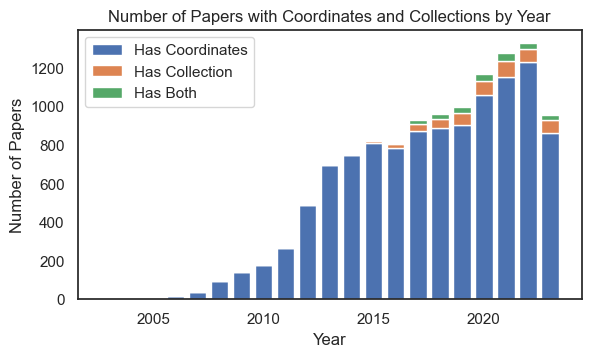

In [9]:
df_counts = nv_coordinate_counts.groupby("publication_year").size().reset_index(name="counts")

# Separate the counts into two columns based on whether the row has a coordinate or a collection
df_counts["has_only_coordinates"] = (
    nv_coordinate_counts.groupby("publication_year")["has_only_coordinates"].sum().values
)
df_counts["has_only_collection"] = (
    nv_coordinate_counts.groupby("publication_year")["has_only_collection"].sum().values
)
df_counts["has_both"] = nv_coordinate_counts.groupby("publication_year")["has_both"].sum().values

# Set the figure size and create a bar plot
height = 3.5
width = 6.5
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(width, height)

plt.bar(df_counts["publication_year"], df_counts["has_only_coordinates"], label="Has Coordinates")
plt.bar(
    df_counts["publication_year"],
    df_counts["has_only_collection"],
    bottom=df_counts["has_only_coordinates"],
    label="Has Collection",
)
plt.bar(
    df_counts["publication_year"],
    df_counts["has_both"],
    bottom=df_counts["has_only_collection"] + df_counts["has_only_coordinates"],
    label="Has Both",
)

# Add labels and titles
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.title("Number of Papers with Coordinates and Collections by Year")
plt.legend()
fig.savefig(op.join(fig_dir, "00_coords_and_coll_by_year.png"), bbox_inches="tight", dpi=DPI)
plt.show()

### Collections per year


In [10]:
collections_by_year = collections[["id", "add_date", "DOI"]].rename(columns={"add_date": "year"})
years = [date.split("-")[0] for date in collections_by_year["year"]]
collections_by_year["year"] = years
# Drop 2024 collecitons
collections_by_year = collections_by_year[collections_by_year["year"] != "2024"]
collections_by_year_df = collections_by_year.groupby("year").size()
collections_by_year_doi_df = collections_by_year.dropna(subset=["DOI"]).groupby("year").size()

In [11]:
collections[["id", "add_date", "DOI"]].to_csv(op.join(fig_dir, "01_collections_by_add-date.csv"))

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


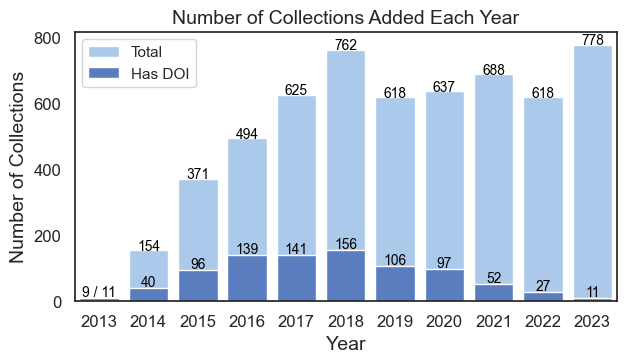

In [12]:
height = 3.5
width = (collections_by_year_df.shape[0] + 3) / 2
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(width, height)

sns.set_color_codes("pastel")
sns.barplot(data=collections_by_year_df, label="Total", color="b", ax=ax)
for i, v in enumerate(collections_by_year_df.values):
    if i != 0:
        ax.text(i, v + 0.5, str(v), color="black", ha="center", fontsize=FONTSIZE - 2)
    else:
        pre = v  # Save the first value for later

sns.set_color_codes("muted")
sns.barplot(data=collections_by_year_doi_df, label="Has DOI", color="b", ax=ax)
for i, v in enumerate(collections_by_year_doi_df.values):
    label = f"{str(v)} / {pre}" if i == 0 else str(v)
    ax.text(i, v + 5, label, color="black", ha="center", fontsize=FONTSIZE - 2)

ax.legend(ncol=1, loc="upper left", frameon=True)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
ax.set_xlabel("Year", fontsize=FONTSIZE + 2)
ax.set_ylabel("Number of Collections", fontsize=FONTSIZE + 2)
ax.set_title("Number of Collections Added Each Year", fontsize=FONTSIZE + 2)
fig.savefig(op.join(fig_dir, "01_collections_by_year.png"), bbox_inches="tight", dpi=DPI)
plt.show()

### Proporion of private collections


In [13]:
collection_by_private = collections.groupby("private").size()
collection_by_private = pd.DataFrame(collection_by_private)
collection_by_private = collection_by_private.rename(
    columns={collection_by_private.columns[0]: "count"}
)
collection_by_private = collection_by_private.reset_index()
collection_by_private["private"] = collection_by_private["private"].replace(
    {"f": "Public", "t": "Private"}
)

In [36]:
fig = _plot_pie(collection_by_private, "count", "private", text_inside=True)
fig.update_layout(
    legend=dict(xanchor='left', yanchor='middle', y=0.5, x=1),
    margin=dict(l=50, r=0, t=0, b=0),
    autosize=True
)
fig.write_html(
    op.join(fig_dir, "02_collections_private.html"), full_html=True, include_plotlyjs=True
)
fig.write_image(op.join(fig_dir, "02_collections_private.png"), scale=6)
fig.show()

## Images per year


In [37]:
statisticmap_merged_red = statisticmap_merged[
    statisticmap_merged.collection_id.isin(collections.id)
]
img_years = [date.split("-")[0] for date in statisticmap_merged_red["add_date"]]
statisticmap_merged_red["year"] = img_years

images_by_year = statisticmap_merged_red[
    ["image_ptr_id", "year", "cognitive_paradigm_cogatlas_id", "cognitive_contrast_cogatlas_id"]
]
images_by_year = images_by_year[images_by_year["year"] != "2024"]
images_by_year_df = images_by_year.groupby("year").size()
images_by_year_task_df = (
    images_by_year.dropna(subset=["cognitive_paradigm_cogatlas_id"]).groupby("year").size()
)
images_by_year_contrast_df = (
    images_by_year.dropna(subset=["cognitive_contrast_cogatlas_id"])[
        images_by_year["cognitive_contrast_cogatlas_id"] != "Other"
    ]
    .groupby("year")
    .size()
)

/var/folders/m9/_ygtgkg17990695673wz4l78j5bsz9/T/ipykernel_35559/3187889338.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/m9/_ygtgkg17990695673wz4l78j5bsz9/T/ipykernel_35559/3187889338.py:16: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

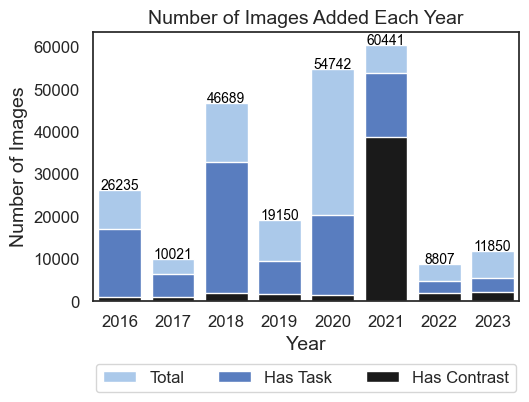

In [38]:
height = 3.5
width = (images_by_year_df.shape[0] + 3) / 2
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(width, height)

sns.set_color_codes("pastel")
sns.barplot(data=images_by_year_df, label="Total", color="b", ax=ax)
for i, v in enumerate(images_by_year_df.values):
    ax.text(i, v + 100, str(v), color="black", ha="center", fontsize=FONTSIZE - 2)

sns.set_color_codes("muted")
sns.barplot(data=images_by_year_task_df, label="Has Task", color="b", ax=ax)
sns.barplot(data=images_by_year_contrast_df, label="Has Contrast", color="k", ax=ax)

ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
ax.set_xlabel("Year", fontsize=FONTSIZE + 2)
ax.set_ylabel("Number of Images", fontsize=FONTSIZE + 2)
ax.set_title("Number of Images Added Each Year", fontsize=FONTSIZE + 2)
fig.savefig(op.join(fig_dir, "03_images_by_year.png"), bbox_inches="tight", dpi=DPI)
plt.show()

### Images thresholded


In [39]:
images_thresholded = statisticmap_merged_red.groupby("is_thresholded").size()
images_thresholded = pd.DataFrame(images_thresholded)
images_thresholded = images_thresholded.rename(columns={images_thresholded.columns[0]: "count"})
images_thresholded = images_thresholded.reset_index()
images_thresholded["is_thresholded"] = images_thresholded["is_thresholded"].replace(
    {"f": "Unthresholded", "t": "Thresholded"}
)

In [40]:
fig = _plot_pie(images_thresholded, "count", "is_thresholded", text_inside=True)
fig.update_layout(
    legend=dict(xanchor='left', yanchor='middle', y=0.5, x=1),
    margin=dict(l=50, r=0, t=0, b=0),
    autosize=True
)
fig.write_html(
    op.join(fig_dir, "04_images_thresholded.html"), full_html=True, include_plotlyjs=True
)
fig.write_image(op.join(fig_dir, "04_images_thresholded.png"), scale=6)
fig.show()

### Image type

### Images in MNI


In [41]:
images_mni = statisticmap_merged_red.groupby("not_mni").size()
images_mni = pd.DataFrame(images_mni)
images_mni = images_mni.rename(columns={images_mni.columns[0]: "count"})
images_mni = images_mni.reset_index()
images_mni["not_mni"] = images_mni["not_mni"].replace({"f": "MNI", "t": "Not MNI"})

In [42]:
fig = _plot_pie(images_mni, "count", "not_mni")
fig.update_layout(
    legend=dict(xanchor='left', yanchor='middle', y=0.5, x=1),
    margin=dict(l=50, r=0, t=0, b=0),
    autosize=True
)
fig.write_html(op.join(fig_dir, "05_images_mni.html"), full_html=True, include_plotlyjs=True)
fig.write_image(op.join(fig_dir, "05_images_mni.png"), scale=6)
fig.show()

### Image modality


In [43]:
image_by_modality = statisticmap_merged_red.groupby("modality").size()
image_by_modality = pd.DataFrame(image_by_modality)
image_by_modality = image_by_modality.rename(columns={image_by_modality.columns[0]: "count"})
image_by_modality = image_by_modality.reset_index()

In [48]:
fig = _plot_pie(image_by_modality, "count", "modality", textinfo="value")
fig.update_layout(
    legend=dict(xanchor='left', yanchor='middle', y=0.5, x=1),
    margin=dict(l=50, r=0, t=100, b=0),
    autosize=True
)
fig.write_html(
    op.join(fig_dir, "06_images_by_modality.html"), full_html=True, include_plotlyjs=True
)
fig.write_image(op.join(fig_dir, "06_images_by_modality.png"), scale=6)
fig.show()

### Map type


In [81]:
statisticmap_fmri_temp = statisticmap_merged_red[statisticmap_merged_red.modality == "fMRI-BOLD"]
Other_mapping = {
    "P": "Other",
    "F": "Other",
    "IP": "Other",
    "M": "Other",
    "Pa": "Other",
    "A": "Other",
    "V": "Other",
    "X2": "Other",
}
statisticmap_fmri_temp["map_type"] = statisticmap_fmri_temp["map_type"].replace(Other_mapping)
image_by_type = statisticmap_fmri_temp.groupby("map_type").size()
image_by_type = pd.DataFrame(image_by_type)
image_by_type = image_by_type.rename(columns={image_by_type.columns[0]: "count"})
image_by_type = image_by_type.reset_index()

MAP_TYPE_CHOICES = {
    "T": "T map",
    "Z": "Z map",
    "F": "F map",
    "X2": "Chi squared map",
    "P": "P map (given null hypothesis)",
    "IP": '1-P map ("inverted" probability)',
    "M": "multivariate-beta map",
    "U": "univariate-beta map",
    "R": "ROI/mask",
    "Pa": "parcellation",
    "A": "anatomical",
    "V": "variance",
    "Other": "other",
}
image_by_type["map_type"] = image_by_type["map_type"].replace(MAP_TYPE_CHOICES)

/var/folders/m9/_ygtgkg17990695673wz4l78j5bsz9/T/ipykernel_35559/1759541125.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [87]:
statisticmap_merged_red[statisticmap_merged_red.modality == "fMRI-BOLD"].groupby("map_type").size()

map_type
A          176
F          571
IP         383
M          383
Other    22048
P          591
Pa         375
R         5432
T        57071
U        13939
V           63
X2          26
Z        95674
dtype: int64

In [82]:
image_by_type

,map_type,count
0,other,24616
1,ROI/mask,5432
2,T map,57071
3,univariate-beta map,13939
4,Z map,95674


In [86]:
fig = _plot_pie(image_by_type, "count", "map_type", width=1.6, height=1.1, textinfo="value")
fig.update_layout(
    legend=dict(xanchor='left', yanchor='middle', y=0.5, x=1),
    margin=dict(l=50, r=0, t=0, b=0),
    autosize=True
)
fig.write_html(
    op.join(fig_dir, "07_images_by_maptype.html"), full_html=True, include_plotlyjs=True
)
fig.write_image(op.join(fig_dir, "07_images_by_maptype.png"), scale=6)
fig.show()

### Analysis level


In [60]:
image_by_analysis = statisticmap_fmri.groupby("analysis_level").size()
image_by_analysis = pd.DataFrame(image_by_analysis)
image_by_analysis = image_by_analysis.rename(columns={image_by_analysis.columns[0]: "count"})
image_by_analysis = image_by_analysis.reset_index()

ANALYSIS_LEVEL_CHOICES = {
    "S": "single-subject",
    "G": "group",
    "M": "meta-analysis",
    "Other": "other",
}
image_by_analysis["analysis_level"] = image_by_analysis["analysis_level"].replace(
    ANALYSIS_LEVEL_CHOICES
)

In [81]:
statisticmap_fmri.groupby("analysis_level").count()

,image_ptr_id,map_type,statistic_parameters,smoothness_fwhm,contrast_definition,contrast_definition_cogatlas,modality,cognitive_paradigm_cogatlas_id,ignore_file_warning,is_thresholded,...,waist_hip_ratio,id,name,description,add_date,modify_date,collection_id,polymorphic_ctype_id,is_valid,year
analysis_level,,,,,,,,,,,,,,,,,,,,,
G,18047,18047,623,1276,2566,0,18047,16020,18047,17660,...,0,18047,18047,12396,18047,18047,18047,18047,18047,18047
M,1911,1911,1,11,157,0,1911,683,1911,1812,...,0,1911,1911,1307,1911,1911,1911,1911,1911,1911
Other,1563,1563,0,6,2,0,1563,1419,1563,1503,...,0,1563,1563,1405,1563,1563,1563,1563,1563,1563
S,158604,158604,0,98,89927,0,158604,144377,158604,158572,...,0,158604,158604,30765,158604,158604,158604,158604,158604,158604


In [93]:
statisticmap_fmri.shape

(196732, 53)

In [95]:
statisticmap_fmri.dropna(subset="analysis_level").groupby("collection_id").size()

collection_id
3         2
16       30
25        1
34        1
35        1
         ..
16413     7
16415     4
16419     1
16420     4
16436     1
Length: 2240, dtype: int64

In [61]:
collection_by_analysis = pd.DataFrame(columns=["collection_id"])
for analysis_level in ["S", "G", "Other"]:
    analysis_df = pd.DataFrame(
        statisticmap_fmri[statisticmap_fmri["analysis_level"] == analysis_level].groupby("collection_id").size()
    )
    analysis_df = analysis_df.rename(columns={analysis_df.columns[0]: analysis_level})
    analysis_df = analysis_df.reset_index()
    collection_by_analysis = pd.merge(
        collection_by_analysis,
        analysis_df,
        how="outer",
    )

In [62]:
has_s = collection_by_analysis["S"].isna() == False
has_g = collection_by_analysis["G"].isna() == False
# has_m = collection_by_analysis["M"].isna() == False
has_o = collection_by_analysis["Other"].isna() == False

In [63]:
for i, row in collection_by_analysis.iterrows():
    # if has_s[i] and has_g[i] and has_m[i] and has_o[i]:
    #    collection_by_analysis.loc[i, "analysis_level"] = "All"
    #elif has_s[i] and has_g[i] and has_m[i]:
    #    collection_by_analysis.loc[i, "analysis_level"] = "SGM"
    if has_s[i] and has_g[i]:
        collection_by_analysis.loc[i, "analysis_level"] = "SG"
    # elif has_s[i] and has_m[i]:
    #     collection_by_analysis.loc[i, "analysis_level"] = "SM"
    # elif has_g[i] and has_m[i]:
    #     collection_by_analysis.loc[i, "analysis_level"] = "GM"
    elif has_s[i]:
        collection_by_analysis.loc[i, "analysis_level"] = "S"
    elif has_g[i]:
        collection_by_analysis.loc[i, "analysis_level"] = "G"
    # elif has_m[i]:
    #     collection_by_analysis.loc[i, "analysis_level"] = "M"
    else:
        collection_by_analysis.loc[i, "analysis_level"] = "Other"

In [64]:
collection_by_analysis_df = collection_by_analysis.groupby("analysis_level").size()
collection_by_analysis_df = pd.DataFrame(collection_by_analysis_df)
collection_by_analysis_df = collection_by_analysis_df.rename(columns={collection_by_analysis_df.columns[0]: "count"})
collection_by_analysis_df = collection_by_analysis_df.reset_index()
label_mapping = {
    "All": "All",
    "SGM": "single-subject & group & meta-analysis",
    "SG": "single-subject & group",
    "SM": "single-subject & meta-analysis",
    "GM": "group & meta-analysis",
    "S": "single-subject",
    "G": "group",
    "M": "meta-analysis",
    "Other": "other",
}
collection_by_analysis_df["analysis_level"] = collection_by_analysis_df["analysis_level"].replace(
    label_mapping
)

In [91]:
fig = _plot_pie(collection_by_analysis_df, "count", "analysis_level", width=1.5, height=1, textinfo="value")
fig.update_layout(
    legend=dict(xanchor='left', yanchor='middle', y=0.5, x=1),
    margin=dict(l=50, r=0, t=0, b=0),
    autosize=True
)
fig.write_html(
    op.join(fig_dir, "08_collection_by_analysis.html"), full_html=True, include_plotlyjs=True
)
fig.write_image(op.join(fig_dir, "08_collection_by_analysis.png"), scale=6)
fig.show()

In [77]:
fig = _plot_pie(image_by_analysis, "count", "analysis_level", width=1.3, height=1, textinfo="value")
fig.update_layout(
    legend=dict(xanchor='left', yanchor='middle', y=0.5, x=1),
    margin=dict(l=50, r=0, t=0, b=0),
    autosize=True
)
fig.write_html(
    op.join(fig_dir, "08_images_by_analysis.html"), full_html=True, include_plotlyjs=True
)
fig.write_image(op.join(fig_dir, "08_images_by_analysis.png"), scale=6)
fig.show()

### Cognitive atlas task representation


In [36]:
statisticmap_fmri_cogat = statisticmap_fmri.dropna(subset=["cognitive_paradigm_cogatlas_id"])[
    ["cognitive_paradigm_cogatlas_id", "image_ptr_id"]
]
statisticmap_fmri_cogat = pd.merge(
    statisticmap_fmri_cogat,
    cogat_task,
    how="left",
    left_on="cognitive_paradigm_cogatlas_id",
    right_on="cog_atlas_id",
)

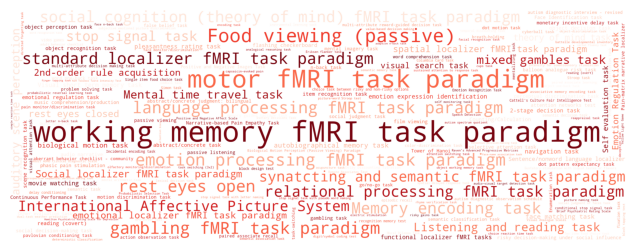

In [37]:
width, height = 8, 3
fig, ax = plt.subplots(figsize=(width, height))

frequencies_dict = dict(statisticmap_fmri_cogat.groupby("name").size())

wc = WordCloud(
    width=width * DPI,
    height=height * DPI,
    background_color="white",
    random_state=0,
    colormap="Reds",
)
wc.generate_from_frequencies(frequencies=frequencies_dict)
ax.imshow(wc)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
for spine in ax.spines.values():
    spine.set_visible(False)


fig.savefig(op.join(fig_dir, "09_cogat_count.png"), bbox_inches="tight", dpi=DPI)
plt.show()

### Image by modalities and map type


In [38]:
# Initialize the list for sunburst plot
labels = ["NeuroVault"]
parents = [""]
values = [statisticmap_merged_red.shape[0]]
statisticmap_with_filled = statisticmap_merged_red.copy()
statisticmap_with_filled["modality"] = statisticmap_with_filled["modality"].fillna("Missing")
statisticmap_with_filled["map_type"] = statisticmap_with_filled["map_type"].replace(
    {"Other": "Others"}
)
modalities = statisticmap_with_filled.modality.unique()
for modality in modalities:
    labels.append(modality)
    parents.append("NeuroVault")
    values.append(statisticmap_with_filled[statisticmap_with_filled.modality == modality].shape[0])
    if modality == "fMRI-BOLD":
        map_types = statisticmap_with_filled.map_type.unique()
        for map_type in map_types:
            labels.append(map_type)
            parents.append(modality)
            values.append(
                statisticmap_with_filled.query(
                    f'modality == "fMRI-BOLD" & map_type == "{map_type}"'
                ).shape[0]
            )

In [39]:
import plotly.graph_objects as go

fig = go.Figure(
    go.Sunburst(
        labels=labels,
        parents=parents,
        values=values,
        branchvalues="total",
    )
)
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.write_html(op.join(fig_dir, "10_images_sunburst.html"), full_html=True, include_plotlyjs=True)
fig.show()

# Collections with linked to PubMed


In [69]:
coll_per_source = collections_pmid_df.groupby("source").size().sort_values(ascending=False)
coll_per_source = pd.DataFrame(coll_per_source)
coll_per_source = coll_per_source.rename(columns={coll_per_source.columns[0]: "count"})
coll_per_source = coll_per_source.reset_index()
new_row = pd.DataFrame(
    {"source": ["PMIDs Missing"], "count": [len(collections) - len(collections_pmid_df)]}
)
coll_per_source = pd.merge(coll_per_source, new_row, how="outer")

In [70]:
mapping = {
    "neurovault": "DOI in NV",
    "pubmed": "Title matching PubMed",
    "pubget": "Pubget search",
    "metadata": "DOI in description",
    "neurosynth": "Neurosynth Scraping",
}
coll_per_source["source"] = coll_per_source["source"].replace(mapping)

In [79]:
fig = px.pie(
    coll_per_source,
    values="count",
    names="source",
    color_discrete_sequence=px.colors.sequential.RdBu,
)
fig.update_traces(textinfo="value")
fig.update_layout(
    legend=dict(xanchor='left', yanchor='middle', y=0.5, x=1),
    margin=dict(l=50, r=0, t=0, b=0),
    height=1 * DPI,
    width=1.5 * DPI,
    autosize=True,
)
fig.write_html(op.join(fig_dir, "11_collections_pmid.html"), full_html=True, include_plotlyjs=True)
fig.write_image(op.join(fig_dir, "11_collections_pmid.png"), scale=6)
fig.show()

### Cognitive atlas task representation


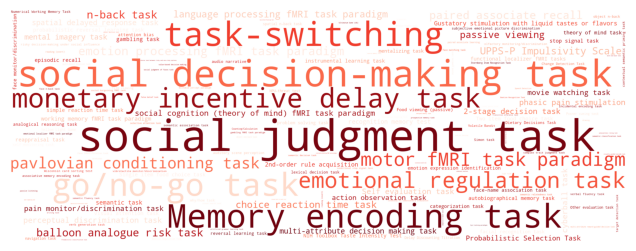

In [45]:
width, height = 8, 3
fig, ax = plt.subplots(figsize=(width, height))

frequencies_dict = dict(
    statisticmap_colelctions.groupby("cognitive_paradigm_cogatlas_name").size()
)

wc = WordCloud(
    width=width * DPI,
    height=height * DPI,
    background_color="white",
    random_state=0,
    colormap="Reds",
)
wc.generate_from_frequencies(frequencies=frequencies_dict)
ax.imshow(wc)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
for spine in ax.spines.values():
    spine.set_visible(False)


fig.savefig(op.join(fig_dir, "12_cogat_count_pubmed.png"), bbox_inches="tight", dpi=DPI)
plt.show()

### NeuroVault reuse


In [101]:
pubget_metadata_fn = op.join(
    pubget_dir,
    query_neurovault,
    "subset_allArticles_extractedData",
    "metadata.csv",
)
pubget_nv_fn = op.join(
    pubget_dir,
    query_neurovault,
    "subset_allArticles_extractedData",
    "neurovault_collections.csv",
)
pubget_nv_df = pd.read_csv(pubget_nv_fn)
pubget_metadata_df = pd.read_csv(pubget_metadata_fn)

# Convert private_token to collection_id
collection_ids = pubget_nv_df["collection_id"].to_list()
pubget_nv_df["collection_id"] = [
    _convert_collection_id(id_, collections) for id_ in collection_ids
]

# Get PMIDs and PMCIDs from metadata
pubget_nv_df = pd.merge(pubget_nv_df, pubget_metadata_df[["pmcid", "pmid", "doi"]], on="pmcid")
pubget_nv_df = pubget_nv_df.reindex(columns=["pmid", "pmcid", "doi", "collection_id"])
pubget_nv_df = pubget_nv_df.rename(columns={"doi": "secondary_doi"})
pubget_nv_df["pmid"] = pubget_nv_df["pmid"].astype("Int64")
pubget_nv_df = pubget_nv_df.dropna(
    subset=["collection_id"]
)  # Some private collections couldnt be mapped to public ones

# Get collections found by pubget
collections_pmid_nnan_df = collections_pmid_df.dropna(subset=["pmid"])
pubget_nv_df

,pmid,pmcid,secondary_doi,collection_id
0,31772347,6879500,10.1038/s41598-019-53985-7,4501.0
1,26322322,4543077,10.1016/j.dib.2015.07.028,550.0
2,36952384,10068819,10.1073/pnas.2120288120,3731.0
3,34296157,8152844,10.1093/texcom/tgab008,262.0
4,26884746,4738700,10.1155/2016/2094601,786.0
...,...,...,...,...
661,35343102,9131432,10.1002/advs.202105336,11813.0
662,30793072,6326731,10.1162/netn_a_00050,3179.0
663,28018192,5147411,10.3389/fnhum.2016.00610,1508.0
664,36617994,10028637,10.1002/hbm.26199,9576.0


In [102]:
neurosynth_nv_fn = op.join(data_dir, "neurosynth", "neurovault_collections.csv")
neurosynth_metadata_fn = op.join(data_dir, "neurosynth", "metadata.csv")
neurosynth_nv_df = pd.read_csv(neurosynth_nv_fn)
neurosynth_metadata_df = pd.read_csv(neurosynth_metadata_fn)

# Convert private_token to collection_id
collection_ids = neurosynth_nv_df["collection_id"].to_list()
neurosynth_nv_df["collection_id"] = [
    _convert_collection_id(id_, collections) for id_ in collection_ids
]

# Get PMIDs and PMCIDs from metadata
neurosynth_nv_df = pd.merge(neurosynth_nv_df, neurosynth_metadata_df[["pmid", "doi"]], on="pmid")
neurosynth_nv_df = neurosynth_nv_df.reindex(columns=["pmid", "doi", "collection_id"])
neurosynth_nv_df = neurosynth_nv_df.rename(columns={"doi": "secondary_doi"})
neurosynth_nv_df["pmid"] = neurosynth_nv_df["pmid"].astype("Int64")
neurosynth_nv_df = neurosynth_nv_df.dropna(
    subset=["collection_id"]
)  # Some private collections couldnt be mapped to public ones
neurosynth_nv_df

,pmid,secondary_doi,collection_id
0,25935068,10.1016/j.biopsych.2015.03.027,394
1,27845254,10.1016/j.neuroimage.2016.11.009,1904
2,27845254,10.1016/j.neuroimage.2016.11.009,1904
3,27851996,10.1016/j.neuroimage.2016.11.019,978
4,27864079,10.1016/j.neuroimage.2016.11.029,1949
...,...,...,...
185,36513365,10.1093/cercor/bhac479,13248
186,36639935,10.1093/scan/nsac062,9265
187,36721902,10.1093/cercor/bhac522,10011
188,36812783,10.1016/j.neurobiolaging.2023.01.011,12828


In [108]:
pd.merge(pubget_nv_df, neurosynth_nv_df, how="outer", on=["pmid", "collection_id"]).groupby("collection_id").size().sort_values(ascending=False).head(10)

collection_id
262.0     20
4683.0     8
3731.0     6
2671.0     6
1549.0     6
5914.0     6
3145.0     6
2462.0     5
503.0      4
7731.0     4
dtype: int64

In [107]:
pd.concat([pubget_nv_df, neurosynth_nv_df]).groupby("collection_id").size().sort_values(ascending=False).head(10)

collection_id
262.0     20
4683.0     8
3731.0     6
2671.0     6
5914.0     6
1549.0     6
3145.0     6
2462.0     5
503.0      4
6546.0     4
dtype: int64

In [96]:
nv_coll = collections_pmid_nnan_df["collection_id"].to_list()
pubget_nv_coll = pubget_nv_df["collection_id"].to_list()
matching_ids = np.intersect1d(nv_coll, pubget_nv_coll)

,pmid,pmcid,secondary_doi,collection_id
0,31772347,6879500,10.1038/s41598-019-53985-7,4501.0
1,26322322,4543077,10.1016/j.dib.2015.07.028,550.0
2,36952384,10068819,10.1073/pnas.2120288120,3731.0
3,34296157,8152844,10.1093/texcom/tgab008,262.0
4,26884746,4738700,10.1155/2016/2094601,786.0
...,...,...,...,...
661,35343102,9131432,10.1002/advs.202105336,11813.0
662,30793072,6326731,10.1162/netn_a_00050,3179.0
663,28018192,5147411,10.3389/fnhum.2016.00610,1508.0
664,36617994,10028637,10.1002/hbm.26199,9576.0


In [97]:
nv_reuse_coll = []
matching_ids = matching_ids.astype("int64")
for coll_id in matching_ids:
    # PMID per colleciton in collections_pmid_nnan_df is unique, select the first one

    nv_pmid = collections_pmid_nnan_df[collections_pmid_nnan_df["collection_id"] == coll_id][
        "pmid"
    ].values[0]
    pg_pmids = pubget_nv_df[pubget_nv_df["collection_id"] == coll_id]["pmid"]
    sub_coll = []
    for pmid in pg_pmids:
        if pmid != nv_pmid:
            sub_coll.append(coll_id)
    nv_reuse_coll.extend(list(set(sub_coll)))

nv_reuse_df = pd.DataFrame()
nv_reuse_df["reused"] = ["Reused", "Not Reused"]
nv_reuse_df["count"] = [len(nv_reuse_coll), len(collections_pmid_df) - len(nv_reuse_coll)]

In [98]:
nv_reuse_df

,reused,count
0,Reused,69
1,Not Reused,1412


In [128]:
from collections import Counter

def find_duplicates(nums):
    counter = Counter(nums)
    duplicates = {num: count for num, count in counter.items() if count > 1}
    return duplicates

duplicates = find_duplicates(nv_reuse_coll)

In [133]:
Counter(nv_reuse_coll)

Counter({13: 1,
         33: 1,
         59: 1,
         63: 1,
         262: 1,
         264: 1,
         394: 1,
         445: 1,
         474: 1,
         503: 1,
         550: 1,
         659: 1,
         860: 1,
         1003: 1,
         1206: 1,
         1276: 1,
         1380: 1,
         1549: 1,
         1598: 1,
         1626: 1,
         1653: 1,
         1866: 1,
         1871: 1,
         1952: 1,
         2099: 1,
         2216: 1,
         2462: 1,
         2694: 1,
         2860: 1,
         3035: 1,
         3145: 1,
         3245: 1,
         3324: 1,
         3713: 1,
         3731: 1,
         3739: 1,
         4031: 1,
         4032: 1,
         4048: 1,
         4083: 1,
         4092: 1,
         4099: 1,
         4100: 1,
         4110: 1,
         4162: 1,
         4258: 1,
         4337: 1,
         4563: 1,
         4752: 1,
         5377: 1,
         5706: 1,
         6009: 1,
         6088: 1,
         6618: 1,
         6746: 1,
         7103: 1,
         

In [129]:
duplicates

{}

In [126]:
nv_reuse_df

,reused,count
0,Reused,69
1,Not Reused,1412


In [ ]:
fig = _plot_pie(nv_reuse_df, "count", "reused", reversed=True)
fig.write_html(
    op.join(fig_dir, "13_collections_reused.html"), full_html=True, include_plotlyjs=True
)
fig.write_image(op.join(fig_dir, "13_collections_reused.png"), scale=6)
fig.show()

### Distributions of number of images, collections and cognitive atlas tasks


In [ ]:
pmid_vs_img = statisticmap_colelctions.groupby("pmid").size().sort_values(ascending=True)
pmid_vs_coll = statisticmap_colelctions.groupby("pmid").apply(_n_colls)[pmid_vs_img.index]
coll_vs_img = statisticmap_colelctions.groupby("collection_id").size().sort_values(ascending=True)
coll_vs_cogat = (
    statisticmap_colelctions.groupby("collection_id").apply(_n_cogats).sort_values(ascending=True)
)
cogat_vs_img = statisticmap_colelctions.cognitive_paradigm_cogatlas_name.value_counts(
    dropna=False
).sort_values(ascending=True)
cogat_vs_coll = statisticmap_colelctions.groupby("cognitive_paradigm_cogatlas_name").apply(
    _n_colls
)[cogat_vs_img.index]

In [ ]:
coll_vs_img.sort_values(ascending=False).to_csv(op.join(fig_dir, "14_coll_vs_img.csv"))

In [ ]:
from plotly.subplots import make_subplots

figures = [
    _plot_hist(cogat_vs_coll, "N Collections"),
    _plot_hist(cogat_vs_img, "N Images"),
]
fig = make_subplots(rows=1, cols=len(figures))

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=1, col=i + 1)

fig["layout"]["xaxis"].update(title="N Collections")  # , type="log"
fig["layout"]["xaxis2"].update(title="N Images")
fig["layout"]["yaxis"].update(title="Cognitive Paradigms")
fig["layout"]["yaxis2"].update(showticklabels=False)

fig.update_layout(
    height=30 * 30,
)

fig.write_html(
    op.join(fig_dir, "14_cogat_vs_coll-img.html"), full_html=True, include_plotlyjs=True
)
fig.show()

In [ ]:
from plotly.subplots import make_subplots

figures = [
    _plot_hist(pmid_vs_coll, "N Collections"),
    _plot_hist(pmid_vs_img, "N Images"),
]
fig = make_subplots(rows=1, cols=len(figures))

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=1, col=i + 1)

fig["layout"]["xaxis"].update(title="N Collections")  # , type="log"
fig["layout"]["xaxis2"].update(title="N Images")
fig["layout"]["yaxis"].update(title="PMID")
fig["layout"]["yaxis2"].update(showticklabels=False)

fig.update_layout(
    height=30 * 30,
)

fig.write_html(op.join(fig_dir, "15_pmid_vs_coll-img.html"), full_html=True, include_plotlyjs=True)
fig.show()

### Distribution of words from abstracts of publications


In [ ]:
cogat_dir = op.join(data_dir, "cogat")

vocabulary = _cogat_vocabulary(cogat_dir)

nq_counts_df = _generate_counts(
    pmid_text,
    id_col="pmid",
    vocabulary=vocabulary,
    text_column="abstract",
    tfidf=False,
    max_df=len(pmid_text) - 2,
    min_df=2,
)

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(6, 5, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    return fig, axes

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

model = LatentDirichletAllocation(
    n_components=30,
    max_iter=1000,
    learning_method="batch",
    doc_topic_prior=None,
    topic_word_prior=0.001,
)
doc_topic_weights = model.fit_transform(nq_counts_df)

In [ ]:
vocabulary = nq_counts_df.columns.to_numpy()
fig, _ = plot_top_words(model, vocabulary, 10, "Topics in LDA model")
fig.savefig(op.join(fig_dir, "16_lda_topics.png"), bbox_inches="tight", dpi=DPI)

In [ ]:
width, height = 8, 3
fig, ax = plt.subplots(figsize=(width, height))

frequencies_dict = dict(nq_counts_df.mean(axis=0))

wc = WordCloud(
    width=width * DPI,
    height=height * DPI,
    background_color="white",
    random_state=0,
    colormap="Reds",
)
wc.generate_from_frequencies(frequencies=frequencies_dict)
ax.imshow(wc)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
for spine in ax.spines.values():
    spine.set_visible(False)


fig.savefig(op.join(fig_dir, "17_word_count_pubmed.png"), bbox_inches="tight", dpi=DPI)
plt.show()

### Collections with unique task and multiple images


In [ ]:
coll_with_1cogat = coll_vs_cogat[coll_vs_cogat == 1]
img_per_coll_with_1cogat = coll_vs_img[coll_vs_img.index.isin(coll_with_1cogat.index)]
coll_with_1cogat_mimages = img_per_coll_with_1cogat[img_per_coll_with_1cogat > 1]
coll_with_1cogat_mimages

coll_with_1cogat_mimages_df = pd.DataFrame(coll_with_1cogat_mimages)
coll_with_1cogat_mimages_df = coll_with_1cogat_mimages_df.rename(
    columns={coll_with_1cogat_mimages_df.columns[0]: "n_images"}
)
coll_with_1cogat_mimages_df.to_csv(op.join(data_dir, "nv_colls_with_1cogat_mimages.csv"))